In [7]:
import numpy as np
import networkx as nx
from InfectionModel import MarkovInfectionModel
from itertools import product
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

from plot_utils import plot_graph, plot_infection_times, plot_idea_full_spread_prob
from experiment_utils import make_init_state, run_time_experiment, run_full_spread_experiment

## Make graph with init state

In [2]:
n_nodes = 10
g = nx.complete_graph(n_nodes)
init_state = make_init_state(n_nodes, 0.1, 0.1)

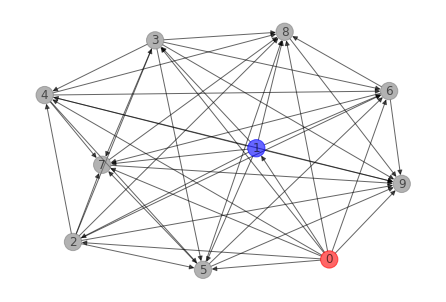

In [3]:
plot_graph(g, init_state)

## Dependence of full spread time from ($\lambda, \mu$)

Full spread means all nodes are infeced with idea or all nodes are infected with anti-idea

In [5]:
lmbda_range = np.round(np.linspace(0.1, 0.9, 9), 1)
mu_range = np.round(np.linspace(0.1, 0.9, 9), 1)

lmbda_mu_pairs = list(product(lmbda_range, mu_range))

In [8]:
partial_time_experiment = partial(run_time_experiment, g=g, init_state=init_state) 

with Pool(cpu_count()) as pool:
    infection_times = list(tqdm(pool.imap(partial_time_experiment, lmbda_mu_pairs), total=len(lmbda_mu_pairs)))
        

100%|██████████| 81/81 [00:17<00:00,  4.68it/s]


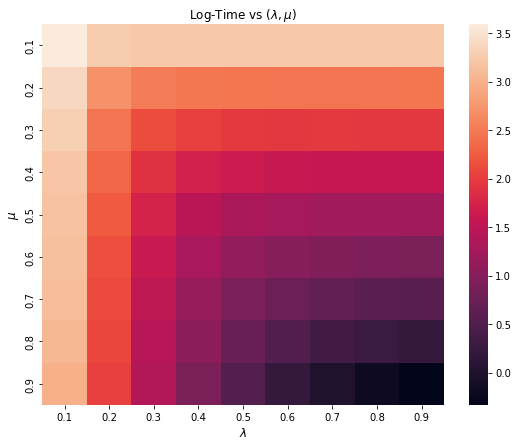

In [9]:
plot_infection_times(infection_times, lmbda_range, mu_range)

## Probability of idea full-spread vs proportion of init idea seeds  

In [12]:
p_minus_range = np.round(np.linspace(0.1, 0.9, 9), 1)
p_plus_range = np.round(np.linspace(0.1, 0.9, 9), 1)

p_minus_plus_pairs = []
for i, p_plus in enumerate(p_plus_range):
    for p_minus in p_minus_range:
        if p_plus + p_minus <= 1:
            p_minus_plus_pairs.append((p_plus, p_minus))

In [13]:
model = MarkovInfectionModel(g, 0.5, 0.5)

In [16]:
partial_full_spread_experiment = partial(run_full_spread_experiment, model=model)

with Pool(cpu_count()) as pool:
    idea_full_spread_prob = list(tqdm(pool.imap(partial_full_spread_experiment, p_minus_plus_pairs), 
                                total=len(p_minus_plus_pairs)))

100%|██████████| 45/45 [00:04<00:00, 11.03it/s]


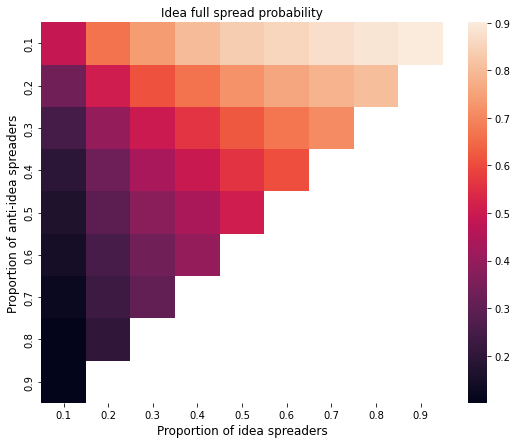

In [17]:
plot_idea_full_spread_prob(idea_full_spread_prob, p_minus_plus_pairs)

**Hypothesis:** 
Denote the number of idea spreaders and anti-idea spreaders in the seed by $I$ and $A$ respectively. Then, for a complete graph, 
$$P(\text{Idea makes a full spread}) =  {I \over A + I}
$$

Indeed, form our MC estiamtes:

In [21]:
p_minus_array, p_plus_array = zip(*p_minus_plus_pairs)
p_minus_array, p_plus_array = np.array(p_minus_array), np.array(p_plus_array)

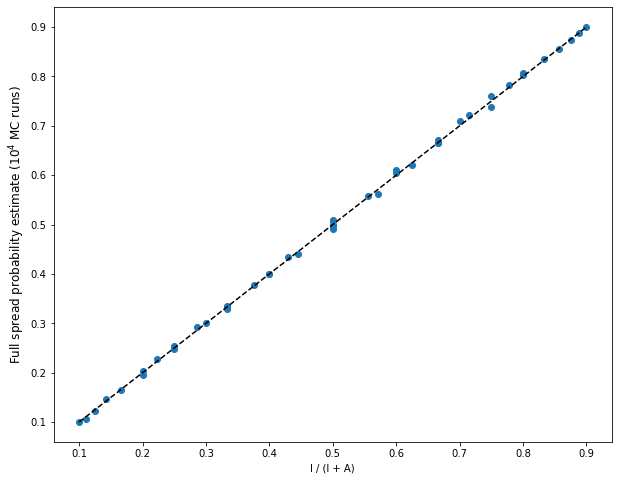

In [47]:
plt.figure(figsize=(10, 8))
plt.scatter(p_minus_array / (p_minus_array + p_plus_array), idea_full_spread_prob)
plt.plot([0.1, 0.9], [0.1, 0.9], linestyle="dashed", c="black")
plt.xlabel("I / (I + A)")
plt.ylabel("Full spread probability estimate ($10^4$ MC runs)", fontsize=12)
plt.show()